In [1]:
import base64
import io
import os
import random

import pandas as pd
import IPython.display as ipd
import librosa as lr
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import PIL
import requests

# Load dataset

In [2]:
path_to_csv = "train_curated.csv"
path_to_data = 'train_curated/'

In [3]:
data_info = pd.read_csv(path_to_csv)
song_list = list(data_info['fname'])
song_paths = [path_to_data + song for song in song_list]
print('Number of files in train dataset:')
print(len(song_list))

Number of files in train dataset:
4970


# Load a sample file for processing

Here we are reading in a song and creating a small player to allow us to judge the mood first.

In [4]:
# First we need set a fixed sample rate to ensusre that all files are read using the same samplerate.
song_number = 9
sample_rate = 44100
song = song_paths[song_number]
audio, sample_rate = lr.load(song, sr=sample_rate)
ipd.Audio(audio, rate=sample_rate)

In [5]:
print(data_info.iloc[song_number]['labels'])

Crowd,Cheering


# Compute the short-time Fourier transform:

First we compute the short-time Fourier transform (STFT for short) of the audio signal. We then store the power of the magnitude as a picure called a spectrogram. As we can see most values show up as black due to the large differances in magnitude across frequencies and time.

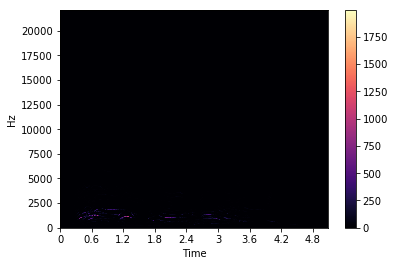

In [6]:
# Complex value STFT
stft = lr.stft(
    audio,
    hop_length=512,
    n_fft=1024,
    center=False
)

# Real value spectrogram
spectrogram = np.abs(stft) ** 2.0

lr.display.specshow(spectrogram, x_axis='time', y_axis='hz', sr=sample_rate)
plt.colorbar()

# Spectrogram to mel scale and dB¶

Next we need to convert to the more compressed mel scale, where frequencies are weighed together in a way that is appropriate for music. Furthermore, the values are expressed in dB, a log based scale which compresses the range of each individual value. This allows us to more clearly see the song's inner structure. This is the final format used when training our music classifer.

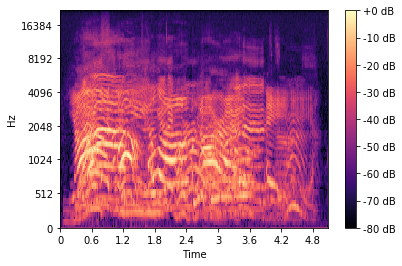

In [7]:
mel_basis = lr.filters.mel(sample_rate, n_fft=1024, n_mels=128, fmax=sample_rate/2, fmin=20)
mel_spectrogram = np.dot(mel_basis, spectrogram)
db_mel_spectrogram = lr.power_to_db(mel_spectrogram, ref=np.max)

lr.display.specshow(db_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, fmax=sample_rate/2)
plt.colorbar(format='%+2.0f dB')
plt.show()

# Rescale to image

The spectrogram contains values in the range [-80, 0] (see the colorbar). To convert this to an image we need values from [0, 255], we therefore rescale to that interval.

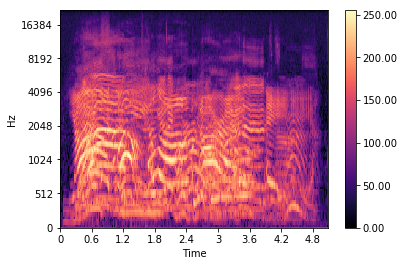

In [8]:
rescaled_db_mel_spectrogram = (db_mel_spectrogram + 80) / 80 * 255

lr.display.specshow(rescaled_db_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, fmax=sample_rate/2)
plt.colorbar(format='%.2f')
plt.show()

# Now compare the sound with the picture and see if you can follow along
# You can feel the 'black' at 27 seconds approach :)
ipd.Audio(audio, rate=sample_rate)

# Create data-uri with spectrogram image¶

Notice how the image is mirrored such that the top corresponds to the lowest frequencies. This is due to how librosa shows spectrograms (indexed from high to low in the vertical direction) compared to how images are shown (indexed from low to high in the vertical direction).


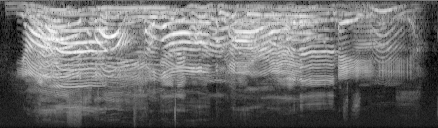

In [10]:
# Use pillow to create PNG without writing to file
image = PIL.Image.fromarray(rescaled_db_mel_spectrogram.astype(np.uint8))
image_bytes = io.BytesIO()
image.convert('L').save(image_bytes, format='png')

# Create data uri
spectrogram_data_uri = 'data:image/png;base64,' + base64.b64encode(image_bytes.getvalue()).decode('utf-8')

# Show
ipd.Image(url=spectrogram_data_uri)

# Crop images 

We want all training images to have an equal size, therefore we crop the images, for simplicity we crop them such that all images are quadradic with an equal size of 128 $\times$ 128 pixels, where to crop the images is choosen at random

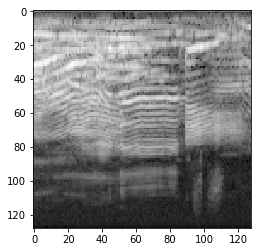

In [11]:
desired_size = 128
if image.size[0] < desired_size or image.size[1] < desired_size:
    new_im = PIL.Image.new("L", (desired_size, desired_size))
    # Paste in the middle 
    new_im.paste(image, ((desired_size-image.size[0])//2,
                        (desired_size-image.size[1])//2))
else:
    new_im = image
# Random crop the image
crop_w = round(random.uniform(0, image.size[0] - desired_size)) 
crop_h = round(random.uniform(0, image.size[1] - desired_size)) 
new_im = new_im.crop((crop_w,crop_h,desired_size+crop_w,desired_size+crop_h))
plt.imshow(new_im, cmap='gray')